In [1]:
import zombie_imp
import csv
import serial
import time 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import pywt

In [2]:
# Initialize the Serial port
ser = serial.Serial('COM3', 115200)  # Change the port and baud rate according to transmitter

# create the CSV file
with open('sensor_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Cell 1', 'Cell 2', 'Cell 3'])  

    # read the data from port and store in CSV file
    try:
        while True:
            data = ser.readline().decode('utf-8').strip()  # read data from port
            if data:
                values = data.split(' ')  # split with space
                if len(values) == 3:  # make sure there are three values
                    writer.writerow([int(val) for val in values])  # store the data
    except KeyboardInterrupt:  # stop iteration by Ctrl+C
        pass

In [5]:
# read the csv file
df = pd.read_csv('sensor_data.csv')

# get the data of each solar cell
solar_cell_1 = df['Cell 1']
solar_cell_2 = df['Cell 2']
solar_cell_3 = df['Cell 3']

# apply DWT for the current value of each solar cell
coeffs_1 = pywt.wavedec(solar_cell_1, 'haar', level=3) #coeffs_1[0] contains the first-level approximation coefficient of solar_cell_1, coeffs_1[1] contains the first-level detail coefficient of solar_cell_1
coeffs_2 = pywt.wavedec(solar_cell_2, 'haar', level=3)
coeffs_3 = pywt.wavedec(solar_cell_3, 'haar', level=3)

print("Coefficients for solar_cell_1:", coeffs_1)
print("Coefficients for solar_cell_2:", coeffs_2)
print("Coefficients for solar_cell_3:", coeffs_3)

Coefficients for solar_cell_1: [array([1471.48921165, 1287.64144854, 1477.85317268, 1471.84276504,
       1459.82194976, 1469.36789131, 1466.18591079, 1400.42498014,
       1331.83562236, 1121.47135496, 1351.28105885, 1466.89301757,
       1371.08004872, 1319.46125369, 1179.45411102, 1480.6815998 ,
       1476.79251251, 1373.20136906, 1319.1077003 , 1222.23407128,
       1256.52875017, 1487.75266762, 1466.89301757, 1331.12851558,
       1220.46630433, 1309.91531215, 1493.05596848, 1470.78210487,
       1351.28105885, 1297.54094348, 1176.2721305 , 1486.33845405,
       1478.56027946, 1329.00719524, 1303.55135112, 1116.87516088,
       1482.09581337, 1483.51002693, 1377.09045636, 1295.77317652,
       1170.26172286, 1388.75771825, 1481.74225998, 1396.18233945,
       1277.7419536 , 1085.76246251, 1293.29830279, 1473.96408538,
       1464.41814384, 1333.95694271, 1263.59981798, 1030.25458019,
       1463.35748367, 1478.20672607, 1463.00393027, 1361.88766057,
       1330.4214088 , 1168.493

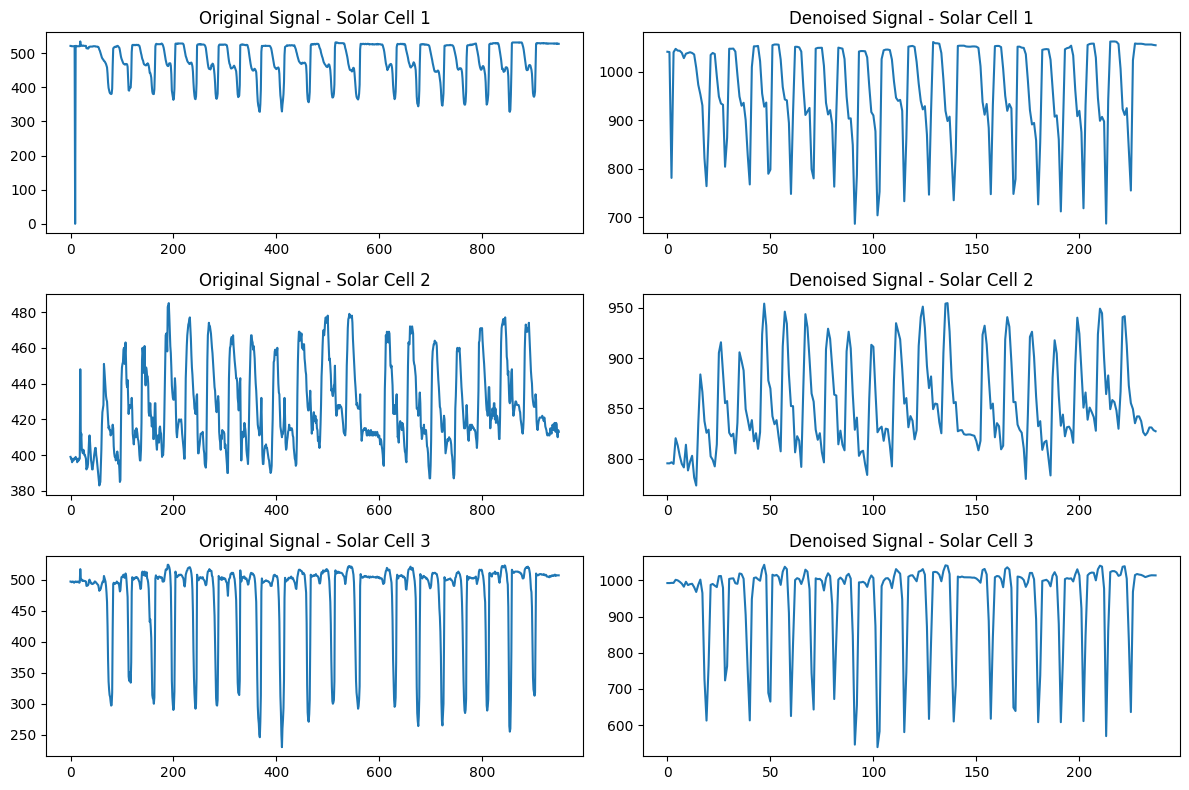

In [7]:
approx_coeff_1 = coeffs_1[0]
detail_coeff_1 = coeffs_1[1]
approx_coeff_2 = coeffs_2[0]
detail_coeff_2 = coeffs_2[1]
approx_coeff_3 = coeffs_3[0]
detail_coeff_3 = coeffs_3[1]

# should be changed based on reality
threshold = 0.3

# apply a threshold on detail coeffcient
detail_coeff_thresh_1 = pywt.threshold(detail_coeff_1, threshold, mode='soft')
detail_coeff_thresh_2 = pywt.threshold(detail_coeff_2, threshold, mode='soft')
detail_coeff_thresh_3 = pywt.threshold(detail_coeff_3, threshold, mode='soft')

# reconstruct the signal
coeffs_denoised_1 = [approx_coeff_1, detail_coeff_thresh_1]
solar_cell_denoised_1 = pywt.waverec(coeffs_denoised_1, 'haar')
coeffs_denoised_2 = [approx_coeff_2, detail_coeff_thresh_2]
solar_cell_denoised_2 = pywt.waverec(coeffs_denoised_2, 'haar')
coeffs_denoised_3 = [approx_coeff_3, detail_coeff_thresh_3]
solar_cell_denoised_3 = pywt.waverec(coeffs_denoised_3, 'haar')


# plot the comparison of single before and after denoising
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(solar_cell_1)
plt.title('Original Signal - Solar Cell 1')

plt.subplot(3, 2, 2)
plt.plot(solar_cell_denoised_1)
plt.title('Denoised Signal - Solar Cell 1')

plt.subplot(3, 2, 3)
plt.plot(solar_cell_2)
plt.title('Original Signal - Solar Cell 2')

plt.subplot(3, 2, 4)
plt.plot(solar_cell_denoised_2)
plt.title('Denoised Signal - Solar Cell 2')

plt.subplot(3, 2, 5)
plt.plot(solar_cell_3)
plt.title('Original Signal - Solar Cell 3')

plt.subplot(3, 2, 6)
plt.plot(solar_cell_denoised_3)
plt.title('Denoised Signal - Solar Cell 3')

plt.tight_layout()
plt.show()